# 3.1 Data Processing
In this exercise we will build a complete EO workflow on a cloud platform; from data access to obtaining the result. 
In this example we will analyse snow cover in the Alps. 
**MORE DETAILS HERE**: This exercise should be more repetition, and the goal is that everybody arrives at the result - without coding very much themselves. Then the transfer application will be done in the sharing exercise

We are going to follow these steps in our analysis:
- Load relevant data sources
- Specify the spatial, temporal extents and the features we are interested in
- Process the satellite data to retreive snow cover information
- aggregate information in data cubes
- Tracking the resources we use for our computation
- Visualize and analyse the results


## Login

In [1]:
pip install rioxarray geopandas leafmap

Note: you may need to restart the kernel to use updated packages.


In [1]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

In [2]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/').authenticate_oidc()

Authenticated using refresh token.


## Region of Interest

Load the catchment area.

In [3]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [4]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

## Inspect Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available datasets.

In [5]:
print(conn.list_collection_ids())

['SENTINEL3_OLCI_L1B', 'SENTINEL3_SLSTR', 'SENTINEL_5P_L2', 'SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1_GRD', 'COPERNICUS_30']


We want to use the Sentinel-2 L2A product. It's name is `'SENTINEL2_L2A'`. 

We get the metadata for this collection as follows.

In [6]:
conn.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018.

In [7]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

In [8]:
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
# temporal_extent = ["2018-02-01", "2018-06-30"]
temporal_extent = ['2018-02-10', '2018-02-13']
bands           = ['B03', 'B11', 'SCL'] # ['B02', 'B03', 'B04', 'CLM']

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

In [13]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent, # put json here
                          bands=bands,
                          temporal_extent=temporal_extent)
s2

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the cloud mask (CLM). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [15]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a timeseries of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.4 on the NDSI. This gives us a binary snow map.

In [26]:
snowmap = ( ndsi > 0.4 ) * 1.0
snowmap

### Creating a cloud mask
We are going to use "SCL" band for creating a cloud mask and then applying it to the NDSI. Here is more information on the Scene Classification https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview


0	NO_DAT; 
1	SATURATED_OR_DEFECTI; E
2	CAST_SHAD; WS
3	CLOUD_SHA; OWS
4	VEGET; TION
5	NOT_VEG; TATED
; 	WATER
7	UNCL; SSIFIED
8	CLOUD_MEDIUM_PR; BABILITY
9	CLOUD_HIGH_P; OBABILITY
10	; HIN_CIRRUS
11	SNOW or ICE

In [27]:
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, NA = cloud

In [28]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Filter Spatial: From Bounding Box to Shape

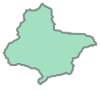

In [29]:
catchment_outline['geometry'][0]

In [30]:
# filter to the exact outline of the catchment: this should mask out the pixels outside of the catchment. The process are doing this not correctly. They base the masking on chunks.
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

### Visualize some time steps of the timeseries
Let's donwload the whole image time series as a netcdf file to have a look how our first results look like

In [65]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-10', '2018-02-13')
snowmap_cloudfree_1d.download('data/snowmap_cloudfree_1d.nc')

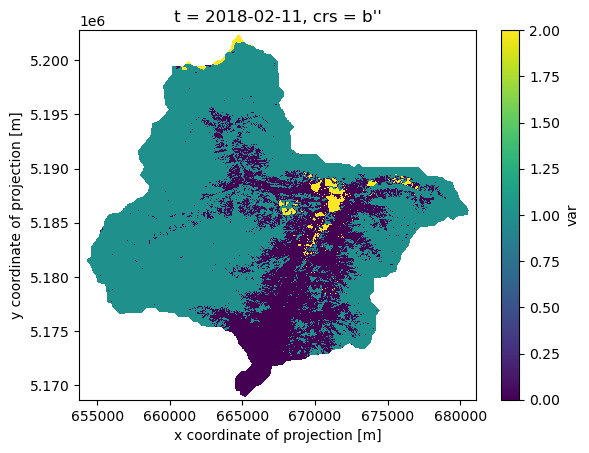

In [31]:
xr.open_dataarray('data/snowmap_cloudfree_1d.nc',decode_coords="all")[0].plot.imshow()

### Cloud Percentage
We are looking at a region over time. We need to make sure that the information content meets our expected quality. Therefore, we calculate the cloud percentage for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 20% will be discarded.

In [33]:
# get number of cloud pixels in catchment
# 1. Create a boolean mask for the clouds in the catchment
# 2. count the cloudy pixels
n_cloud = ((snowmap_cloudfree_masked == 2) * 1.0 ).aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum') # getting a sum of all cloudy pixels, where clouds = 2
n_cloud.download('data/n_cloud.json')

In [34]:
# load number of clouded pixels per time step
with open("data/n_cloud.json","r") as file:
    n_cloud_json = json.load(file)

In [35]:
# check the first 5 entries
list(n_cloud_json.items())[:5]

[('2018-02-11T00:00:00Z', [[67041.0]])]

In [36]:
# get number of all pixels in catchment
n_catchment = snowmap_cloudfree_masked.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'count')
n_catchment.download('data/n_catchment.json')

In [41]:
merged = n_cloud.merge_cubes(n_catchement)

type: 'VectorCube' object has no attribute 'merge_cubes'

In [40]:
# load the number of all pixels in the catchment
with open("data/n_catchment.json","r") as file:
    n_catchment_json = json.load(file)
# check the first 5 entries
list(n_catchment_json.items())[:5]

[('2018-02-11T00:00:00Z', [[4201607.0]])]

In [29]:
# get the values out of the dictionary
n_catchment_vals = [n_catchment_json[k][0][0] for k in n_catchment_json]
n_cloud_vals = [n_cloud_json[k][0][0] for k in n_cloud_json]

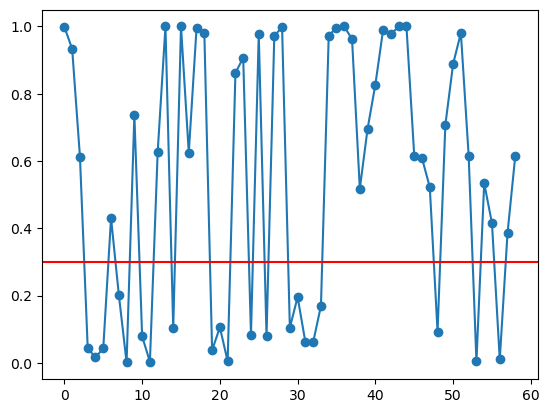

In [35]:
# divide the number of cloudy pixels by the number of total pixels = cloud percentage
perc_cloud = [x[0]/x[1] for x in zip(n_cloud_vals,n_catchment_vals)]

In [ ]:
# plot the cloud percentage and a 30% threshold
plt.plot(perc_cloud, marker='o')
plt.axhline(y = 0.2, color = 'r', linestyle = '-')
plt.show()

In [36]:
# count the number of images below 30%
perc_cloud < 0.2

TypeError: '<' not supported between instances of 'list' and 'float'

### Cloud Mask visualized

In [50]:
# download the whole cloud mask as netcdf to validate
cloud_mask.download('data/cloud_mask.nc') # 17:09, 17:16 = 7 min

In [51]:
cloud_mask_nc = xr.open_dataarray('data/cloud_mask_catchment.nc',decode_coords="all",chunks={})
cloud_mask_nc

<xarray.DataArray 'var' (t: 59, y: 3414, x: 2733)>
dask.array<open_dataset-var, shape=(59, 3414, 2733), dtype=float32, chunksize=(59, 3414, 2733), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) datetime64[ns] 2018-02-01 2018-02-03 ... 2018-06-26 2018-06-28
  * x        (x) float64 6.538e+05 6.538e+05 6.538e+05 ... 6.811e+05 6.811e+05
  * y        (y) float64 5.203e+06 5.203e+06 5.203e+06 ... 5.169e+06 5.169e+06
    crs      |S1 ...
Attributes:
    long_name:  var
    units:

In [ ]:
# mask the cloud mask with the catchment in case filter_spatial and mask_polygon are not working
# filter_spatial and mask_polygon doesn't mask exactly to the outline of the catchment. It looks like it's selecting only the chunks that are within the shape


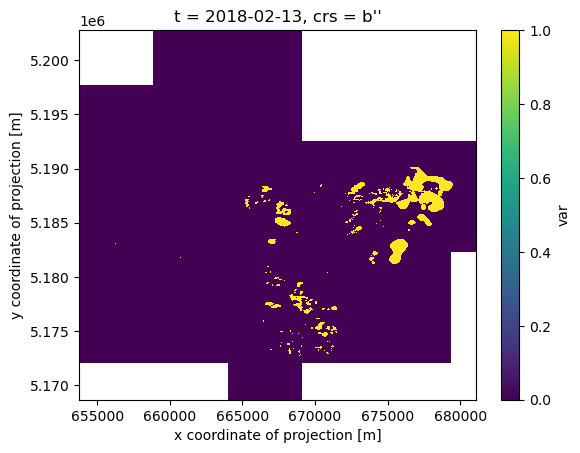

In [52]:
cloud_mask_nc[5].plot.imshow() # low clouds
# cloud_mask_nc[55].plot.imshow() # missing data

### Snow Covered Area in the Catchment
We are interested in the snow covered area (SCA) within the catchment. We count all snow covered pixels within the catchment for each time step. After our snow classification our data cube has the values: 0 = no snow, 1 = snow, NA = cloud. This means we can sum up all pixels within the catchment and the sum will give us the count of the snow covered pixels. Later we can use this number to translate pixel count into area.

In [82]:
n_snow = snowmap.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer="sum")
n_snow

## Download the results
So far no processing has happened! We have only created the workflow instructions. Now we are moving to the step where the actual processing will take place.
Before downloading please run the connection step again to make sure your connection is still active. Then we check the available file formats that the cloud backend supports. This is very important to know, since not all file formats are suitable for all types of information. Finally we will download the results in two different ways.

### Reconnect before downloading
Run the connection cell in the beginning of the script again to make sure your connection is still valid.

### Available File Formats
We check the available file formats that the cloud backend supports. This is very important to know, since not all file formats are suitable for all types of information.

In [28]:
conn.list_file_formats()

{'input': {},
 'output': {'GTiff': {'gis_data_types': ['raster'],
   'parameters': {'datatype': {'default': 'float32',
     'description': 'The values data type.',
     'enum': ['byte', 'uint16', 'float32'],
     'type': 'string'}}},
  'JPEG': {'gis_data_types': ['raster'],
   'parameters': {'datatype': {'default': 'byte',
     'description': 'The values data type.',
     'enum': ['byte'],
     'type': 'string'}}},
  'PNG': {'gis_data_types': ['raster'],
   'parameters': {'datatype': {'default': 'byte',
     'description': 'The values data type.',
     'enum': ['byte', 'uint16'],
     'type': 'string'}}}}}

### Synchronous Download
One way of receiving the data from the cloud platform is via direct download. In this way we tell the platform to execute our workflow while we wait until it is done and then it will be directly downloaded. This blocks our development environment. It is suitable for quickly receiving small amounts of data.

In [37]:
snowarea.download("snowarea.tiff")

OpenEoApiError: [403] TokenInvalid: Authorization token has expired or is invalid. Please authenticate again.

### Batch Job
A second way to receive the results from the platform is to use a batch job, or asynchrounous processing. In this way a job is registered on the backend first. This job is persistently available via it's ID for a given amount of time. The job can be started whenever wanted. It is then executed in the background. Its status can be cecked. When it's done the results can be downloaded. In this way the development environment is not blocked, other things can be done. This is suitable for larger analysis. 

In [84]:
snowmap_fin = snowmap.save_result(format="GTiff")
#snowmap_fin.execute_batch()
snowmap_fin_job = snowmap_fin.create_job(title = "snowmap")
snowmap_fin_job.start_job()

OpenEoApiError: [400] 400: Unable to convert process graph to evalscript: list index out of range

In [40]:
from openeo.rest.auth.config import RefreshTokenStore
RefreshTokenStore().remove()

## Analysis of the results
**we should move this complete step to validation (and rename it to data analysis and validation)**
In a next step we will analyze and validate the results. We are going to compare the SCA timeseries we have derived from satellite observations to runoff measurements at the outlet of the catchment and to snow measurement station data. For now we will have a look at the timeseries. And at a map (one time step or mean of the winter).